<a href="https://colab.research.google.com/github/Junior-sls/Arquivos/blob/main/ESTUDOOUTBREAK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

In [2]:
def manhattan_distance(p1, p2): #Calcula a heurística (Distância de Manhattan) para o A*.
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def calcular_custo_a_estrela(grid, start_point, end_point, TERRAIN_COSTS):
    rows, cols = grid.shape
    #fila de prioridade (f_score, g_score, ponto_atual)
    priority_queue = [(0, 0, start_point)]
    #g Score: custo do início até o ponto atual.
    g_score = { (r, c): float('inf') for r in range(rows) for c in range(cols) }
    g_score[start_point] = 0
    #pontos vizinhos para mover (horizontal e vertical)
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    while priority_queue:
        #pegamos o ponto com o menor f score (g_score + heurística)
        f_score, current_g, current_point = heapq.heappop(priority_queue)
        if current_point == end_point:
            return current_g #retorno do custo
        r, c = current_point
        for dr, dc in neighbors:
            next_r, next_c = r + dr, c + dc
            next_point = (next_r, next_c)
            #verificando limites do grid
            if 0 <= next_r < rows and 0 <= next_c < cols:
                #custo para entrar na nova célula (baseado no terreno)
                terrain_type = grid[next_r, next_c]
                move_cost = TERRAIN_COSTS.get(terrain_type, 1)
                #novo custo real (g_score)
                new_g_score = current_g + move_cost
                if new_g_score < g_score[next_point]:
                    g_score[next_point] = new_g_score
                    #f_score = g_score (custo real) + h_score (custo estimado)
                    h_score = manhattan_distance(next_point, end_point)
                    f_score = new_g_score + h_score
                    heapq.heappush(priority_queue, (f_score, new_g_score, next_point))
    return float('inf')

In [3]:
#algortimo genetico
class GeneticAlgorithmTSP:
    def __init__(self, outbreak_points, costs_matrix, rewards_list, population_size=150, generations=300):
        self.points = outbreak_points
        self.num_points = len(outbreak_points)
        self.costs_matrix = costs_matrix
        self.rewards_list = rewards_list
        self.POP_SIZE = population_size
        self.GENERATIONS = generations
        self.population = self._initialize_population()
        self.best_route = None
        self.best_fitness = -float('inf')
        self.history = []

    def _initialize_population(self): #Criamos uma população inicial de rotas (permutação aleatória de Outbreaks/surtos pokémon).
        population = []
        base_route = list(range(self.num_points))
        for _ in range(self.POP_SIZE):
            route = base_route[:]
            random.shuffle(route)
            population.append(route)
        return population

    def _calculate_fitness(self, route):
        total_cost = 0
        total_reward = 0
        #calcular o custo total
        for i in range(self.num_points):
            start_index = route[i]
            end_index = route[(i + 1) % self.num_points] # Loop de volta ao primeiro
            total_cost += self.costs_matrix[start_index, end_index]
        #calcular recompensa total (consideramos o valor intrínseco de cada Outbreak)
        for index in route:
            #o outbreak é uma 'cidade' com um valor de recompensa
            total_reward += self.rewards_list[index]
        if total_cost == 0:
            return 0
        return total_reward / total_cost
    def _selection(self, population_fitness):
        #aqui a gente ja seleciona por ttrneio (seleciona os 3 melhores de um grupo aleatório).
        #pool de seleção
        pool = random.sample(list(enumerate(population_fitness)), 3)
        #O com maior fitness vence o torneio
        best_index = max(pool, key=lambda x: x[1])[0]
        return self.population[best_index]

    def _crossover_order(self, parent1, parent2):
        #Crossover preservando a ordem de uma seção do pai.
        size = len(parent1)
        a, b = random.sample(range(size), 2)
        start, end = min(a, b), max(a, b)
        child1 = [None] * size
        child2 = [None] * size
        #copiando a seção
        child1[start:end] = parent1[start:end]
        child2[start:end] = parent2[start:end]
        #preenche os espaços restantes, mantendo a ordem do outro pai
        def fill_gaps(child, parent):
            fill_values = [item for item in parent if item not in child]
            fill_index = 0
            for i in range(size):
                if child[i] is None:
                    child[i] = fill_values[fill_index]
                    fill_index += 1
            return child
        return fill_gaps(child1, parent2), fill_gaps(child2, parent1)
    def _mutation(self, route, mutation_rate=0.05): # Taxa aumentada para 5%
        #Mutação por troca: trocamos a posição de dois pontos aleatoriamente.
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(self.num_points), 2)
            route[idx1], route[idx2] = route[idx2], route[idx1]
        return route

    def run(self):
        #Executamos o algoritmo genético por N gerações.
        for generation in range(self.GENERATIONS):
            #avaliacao por fitness
            population_fitness = [self._calculate_fitness(route) for route in self.population]
            #atualizando o melhor individuo encontrado
            max_fitness = max(population_fitness)
            if max_fitness > self.best_fitness:
                self.best_fitness = max_fitness
                self.best_route = self.population[population_fitness.index(max_fitness)]
            self.history.append(max_fitness)
            #criamos uma nova população
            new_population = []
            while len(new_population) < self.POP_SIZE:
                #selção dos pais
                parent1 = self._selection(population_fitness)
                parent2 = self._selection(population_fitness)
                #agora voltando o crossover
                child1, child2 = self._crossover_order(parent1, parent2)
                #mutação
                new_population.append(self._mutation(child1))
                if len(new_population) < self.POP_SIZE:
                    new_population.append(self._mutation(child2))
            self.population = new_population
            # if generation % 50 == 0:
            #     print(f"Geração {generation}: elhor Fitness = {self.best_fitness:.4f}")

        return self.best_route, self.best_fitness

Calculamos a matriz de custos com A* (Nível Micro)
Executando o algoritmo genético (Nível Macro)
Resultados do algortimo genetico:
Melhor fitness encontrada (Recompensa/Custo): 9.7460
Custo total da rota otimizada: 252.00 unidades de tempo/energia

Ordem Otimizada de visita aos Outbreaks:
O7 (R: 401) -> O4 (R: 261) -> O2 (R: 104) -> O0 (R: 488) -> O8 (R: 122) -> O5 (R: 314) -> O6 (R: 209) -> O1 (R: 157) -> O9 (R: 348) -> O3 (R: 52)


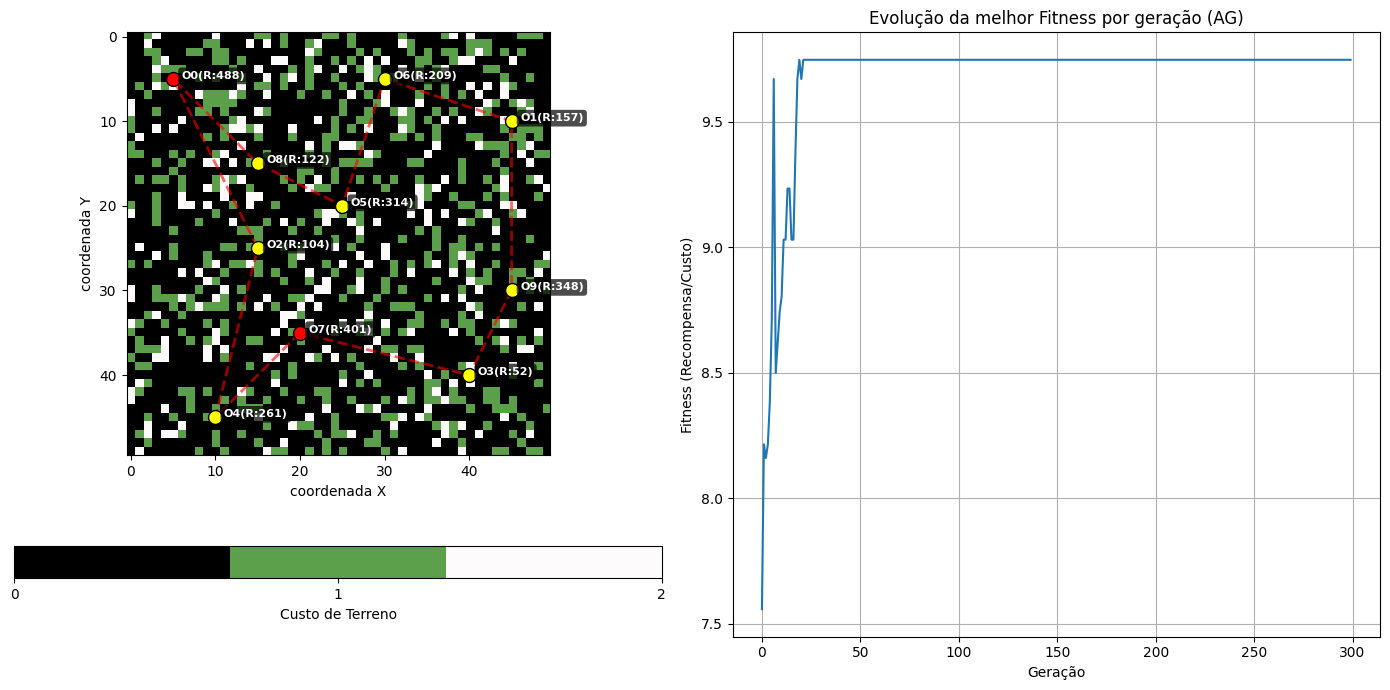

In [5]:
#setup do mapa seguindo as mecânicas do Pokémon Legends: Arceus
GRID_SIZE = 50
#0: Planície (Fácil), 1: Água (Médio), 2: Montanha (Difícil)
TERRAIN_GRID = np.random.choice([0, 1, 2], size=(GRID_SIZE, GRID_SIZE), p=[0.7, 0.2, 0.1])
TERRAIN_COSTS = {
    0: 1,  #Planície: Custo 1
    1: 5,  #Água: Custo 5 (Lento/Exige montaria a aquática Baculegion)
    2: 10, #Montanha: Custo 10 (Muito Lento/Exige montaria escalada Sneasler)
}
#vamo colocar 10 Pontos de Outbreak (Coordenadas Linha, Coluna no mapa 50x50)
OUTBREAK_POINTS = [
    (5, 5),   #O0: Canto superior esquerdo
    (10, 45), #O1: Canto superior direito
    (25, 15), #O2: Centro esquerda
    (40, 40), #O3: Canto inferior direito
    (45, 10), #O4: Canto inferior esquerdo
    (20, 25), #O5: Centralizado
    (5, 30),  #O6: Superior central
    (35, 20), #O7: Inferior central
    (15, 15), #O8: Meio superior
    (30, 45)  #O9: Meio direito
]
#recompensa intrínseca de cada Outbreak (Shiny Comum vs Alpha Shiny)
#lista de recompensas, as recompensas sao calculadas pelo caclculo do valor esperado de todas chances de achar um Pokémon shiny
REWARDS = [
    488, #O0: MUITO ALTO (Alpha Shiny de alto valor) fator 19.5
    157, #O1: Comum 6.3
    104, #O2: Comum 4.1
    52,  #O3: Baixo valor 2.1
    261, #O4: Médio valor 10.4
    314, #O5: Médio/Alto valor 12.5
    209, #O6: Valor mediano 8.3
    401, #O7: ALTO (Alpha Shiny) 16.0
    122, #O8: Valor comum 4.9
    348  #O9: Valor alto 13.9
]
#Pré cálculo da matriz de custos usando A* (Nível Micro)
print("Calculamos a matriz de custos com A* (Nível Micro)")
NUM_OUTBREAKS = len(OUTBREAK_POINTS)
COSTS_MATRIX = np.zeros((NUM_OUTBREAKS, NUM_OUTBREAKS))

for i in range(NUM_OUTBREAKS):
    for j in range(NUM_OUTBREAKS):
        if i != j:
            start = OUTBREAK_POINTS[i]
            end = OUTBREAK_POINTS[j]
            #o A* retorna o menor custo real de travessia (tempo/energia causado pelo tempo de montaria)
            COSTS_MATRIX[i, j] = calcular_custo_a_estrela(TERRAIN_GRID, start, end, TERRAIN_COSTS)
        else:
            COSTS_MATRIX[i, j] = 0

#execução do algoritmo genético (Nível Macro)
print("Executando o algoritmo genético (Nível Macro)")
ag = GeneticAlgorithmTSP(OUTBREAK_POINTS, COSTS_MATRIX, REWARDS, population_size=150, generations=300)
best_route_indices, max_fitness = ag.run()
#conversão da rota de índices para coordenadas
best_route_coords = [OUTBREAK_POINTS[i] for i in best_route_indices]
#recálculo do custo total
#a fitness é (soma das recompensas / custo total), então Custo Total = Soma Recompensas / Fitness
route_reward_sum = sum(REWARDS)
route_cost = route_reward_sum / max_fitness

print("Resultados do algortimo genetico:")
print(f"Melhor fitness encontrada (Recompensa/Custo): {max_fitness:.4f}")
print(f"Custo total da rota otimizada: {route_cost:.2f} unidades de tempo/energia")
print("\nOrdem Otimizada de visita aos Outbreaks:")
print(" -> ".join([f"O{i} (R: {REWARDS[i]})" for i in best_route_indices]))

plt.figure(figsize=(14, 7))
#subplot da visualização do mapa de terreno e rota
plt.subplot(1, 2, 1)
cmap = plt.colormaps['gist_earth'].resampled(3)
plt.imshow(TERRAIN_GRID, cmap=cmap)
plt.colorbar(ticks=[0, 1, 2], label='Custo de Terreno', orientation='horizontal')
#desenhando a rota otimizada
route_x = [c for r, c in best_route_coords]
route_y = [r for r, c in best_route_coords]
#adionando o ponto final para fechar o loop (TSP)
route_x.append(route_x[0])
route_y.append(route_y[0])
plt.plot(route_x, route_y, 'r--', alpha=0.6, linewidth=2, label='Rota AG Otimizada')
#desenhando os outbreaks
for i, (r, c) in enumerate(OUTBREAK_POINTS):
    color = 'red' if REWARDS[i] >= 350 else 'yellow' # Destacamos Alpha Shinies (alto valor)
    plt.plot(c, r, 'o', color=color, markersize=10, markeredgecolor='black')
    plt.text(c + 1, r, f'O{i}(R:{REWARDS[i]})', color='white', fontsize=8, weight='bold',
             bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))
plt.xlabel("coordenada X")
plt.ylabel("coordenada Y")
#subplot da evolução da fitness
plt.subplot(1, 2, 2)
plt.plot(ag.history)
plt.title('Evolução da melhor Fitness por geração (AG)')
plt.xlabel('Geração')
plt.ylabel('Fitness (Recompensa/Custo)')
plt.grid(True)

plt.tight_layout()
plt.show()